### Cramer Rao Lower Bound evaluation

This notebook loads an existing model, generates short 6-frame samples of single emitters, and then uses the model to localize the emitters. The evaluation is done by simply taking the pixel with maximum emitter probability, and using the X,Y outputs of that pixel.

The Cramer Rao Lower Bound is the theoretical best achievable estimation precision, calculated for a 2D Gaussian model and a camera with with Poisson distributed noise on the pixels (typical shot-noise). The CRLB is calculated for the case that all 6 frames are summed into a single frame.

This notebook was tested with the A100 runtime.

In [9]:
# Clone the SIMCODE source code
%cd /content
!git clone https://github.com/jcnossen/simcode.git
%cd /content/simcode/
!pip install -e .

%cd /content
# Google colab now requires either this, or restarting the runtime after doing a local package install
import site
site.main()


/content
fatal: destination path 'simcode' already exists and is not an empty directory.
/content/simcode
Obtaining file:///content/simcode
  Preparing metadata (setup.py) ... done
  Attempting uninstall: smlmtorch
    Found existing installation: smlmtorch 1.0
    Uninstalling smlmtorch-1.0:
      Successfully uninstalled smlmtorch-1.0
  Running setup.py develop for smlmtorch
/content


In [10]:
simcode_model_zip = '/content/simcode/model/model_weights_sf_conv_g1.3_tio2_L64_2.zip'
simcode_model_path = '/content/simcode/model/sf_conv_g1.3_tio2_L64_2/'

!unzip -o {simcode_model_zip} -d /content/simcode/model/

Archive:  /content/simcode/model/model_weights_sf_conv_g1.3_tio2_L64_2.zip
  inflating: /content/simcode/model/sf_conv.ipynb  
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt  
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/config.yaml  
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/intensities_histogram.svg  


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from smlmtorch.util.config_dict import config_dict # dictionary indexable like object
from smlmtorch.nn.sf_model import SFLocalizationModel
from smlmtorch.nn.model_trainer import LocalizationModelTrainer

device = 'cuda:0'

config = config_dict.load(simcode_model_path + '/config.yaml')
trainer = LocalizationModelTrainer(config, SFLocalizationModel, device,
    save_dir = simcode_model_path, load_previous_model = True)  # note that save_dir is only used when trainer.train() is called


CheckpointManager initialized:  /content/simcode/model/sf_conv_g1.3_tio2_L64_2
Loaded checkpoint: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt. Epoch: 172. Learning rate: 6.3e-07


### Plot spot intensity histogram used for training

k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


  0%|          | 0/100 [00:00<?, ?it/s]

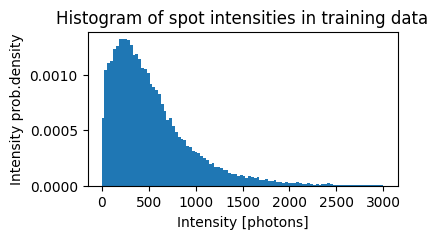

In [12]:
ds = trainer.data_generator.generate(100)
active = ds.spots_ds.spots[:,:,:,0]>0
intensities = ds.spots_ds.spots[:,:,:,1][active]

plt.figure(figsize=(4,2))
plt.hist(intensities, bins=100, range=[0,3000],density=True)
plt.title('Histogram of spot intensities in training data')
plt.ylabel('Intensity prob.density')
plt.xlabel('Intensity [photons]')
plt.savefig(trainer.save_dir+"/intensities_histogram.svg")

### Evaluate single emitter 2D localizatoin performance over a range of photon counts


  0%|          | 0/10 [00:00<?, ?it/s]

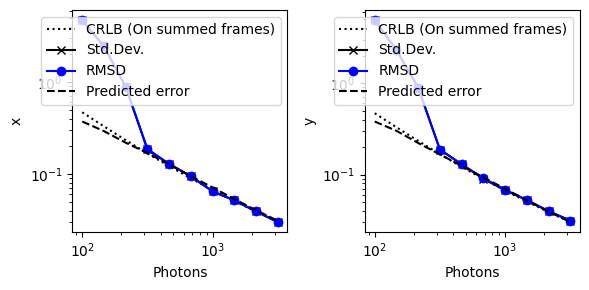

In [13]:
from smlmtorch.nn.benchmark.compare_crlb import CRLBPlotGenerator

photon_range = np.logspace(2, 3.5, 10)

crlb_plotter = CRLBPlotGenerator(trainer.model, 500,
    trainer.data_generator.psf,
    param_list=['x', 'y'],
    psf_param_mapping = ['x', 'y'],
    sim_config=config.simulation, device=device)

crlb_plotter.plot_photon_range(photon_range, background=4,
    n_frames=6, log_step=0, log_writer=None);


The model is confident that it achieves the CRLB, as can be seen by the predicted error being very close to it, even at low photon counts.
However, for low photon counts the measured RMSD does not achieve the CRLB.

## Intensity estimation outputs

TODO
